https://github.com/lyst/lightfm

LightFM is a Python implementation of a number of popular recommendation algorithms for both implicit and explicit feedback, including efficient implementation of BPR and WARP ranking losses. It's easy to use, fast (via multithreaded model estimation), and produces high quality results.

It also makes it possible to incorporate both item and user metadata into the traditional matrix factorization algorithms. It represents each user and item as the sum of the latent representations of their features, thus allowing recommendations to generalise to new items (via item features) and to new users (via user features).

Recommendation Systems - Learn Python for Data Science
https://www.youtube.com/watch?v=9gBC9R-msAk

An implicit feedback recommender for the Movielens dataset
https://github.com/lyst/lightfm/blob/master/examples/movielens/example.ipynb

Learning to Rank Sketchfab Models with LightFM
http://blog.ethanrosenthal.com/2016/11/07/implicit-mf-part-2/


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from lightfm.datasets import fetch_movielens
from lightfm import LightFM
%matplotlib inline

C:\ProgramData\Anaconda2\envs\python36\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
   * 100,000 ratings (1-5) from 943 users on 1682 movies. 
   * Each user has rated at least 20 movies. 
   * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Parameters:	
- data_home (path, optional) – Path to the directory in which the downloaded data should be placed. Defaults to ~/lightfm_data/.
- indicator_features (bool, optional) – Use an [n_items, n_items] identity matrix for item features. When True with genre_features, indicator and genre features are concatenated into a single feature matrix of shape [n_items, n_items + n_genres].
- genre_features (bool, optional) – Use a [n_items, n_genres] matrix for item features. When True with item_indicator_features, indicator and genre features are concatenated into a single feature matrix of shape [n_items, n_items + n_genres].
- min_rating (float, optional) – Minimum rating to include in the interaction matrix.
- download_if_missing (bool, optional) – Download the data if not present. Raises an IOError if False and data is missing.

The return value is a dictionary containing the following keys:

Returns:	
- train (sp.coo_matrix of shape [n_users, n_items]) – Contains training set interactions.
- test (sp.coo_matrix of shape [n_users, n_items]) – Contains testing set interactions.
- item_features (sp.csr_matrix of shape [n_items, n_item_features]) – Contains item features.
- item_feature_labels (np.array of strings of shape [n_item_features,]) – Labels of item features.
- item_labels (np.array of strings of shape [n_items,]) – Items’ titles.

In [2]:
data= fetch_movielens(min_rating=4.0)

In [3]:
for key, value in data.items():
    print(key, type(value), value.shape)

train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


In [4]:
# The train and test elements are the most important: they contain 
# the raw rating data, split into a train and a test set. 
# Each row represents a user, and each column an item. 
# Entries are ratings from 1 to 5.
# show the first row and 500 columns of test data
data['test'].todense()[:1,:100]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [5]:
print(data["item_labels"])
# print(data['item_features'])
# print(data["item_feature_labels"])

['Toy Story (1995)' 'GoldenEye (1995)' 'Four Rooms (1995)' ...
 'Sliding Doors (1998)' 'You So Crazy (1994)'
 'Scream of Stone (Schrei aus Stein) (1991)']


# Explore the data

In [6]:
train_df = pd.DataFrame(data['train'].todense(),
                        columns = data['item_labels'])
train_df = train_df.transpose()
# train_df.groupby(train_df.index).count()
# train_df

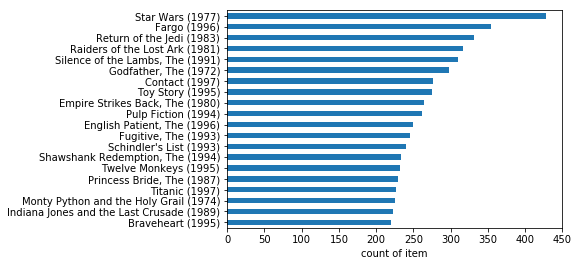

In [7]:
def count_label(x):
    if x>0:
        return True
    else:
        return False

item_count = train_df.applymap(count_label).sum(axis =1)
item_count.sort_values(ascending=False)[0:20][::-1].plot.barh()
plt.xlabel('count of item')

# Training the Hypothesis

An implicit feedback recommender for the Movielens dataset
Implicit feedback
For some time, the recommender system literature focused on explicit feedback: the Netflix prize focused on accurately reproducing the ratings users have given to movies they watched.

Focusing on ratings in this way ignored the importance of taking into account which movies the users chose to watch in the first place, and treating the absence of ratings as absence of information.

But the things that we don't have ratings for aren't unknowns: we know the user didn't pick them. This reflects a user's conscious choice, and is a good source of information on what she thinks she might like.

This sort of phenomenon is described as data which is missing-not-at-random in the literature: the ratings that are missing are more likely to be negative precisely because the user chooses which items to rate. When choosing a restaurant, you only go to places which you think you'll enjoy, and never go to places that you think you'll hate. What this leads to is that you're only going to be submitting ratings for things which, a priori, you expected to like; the things that you expect you will not like you will never rate.

This observation has led to the development of models that are suitable for implicit feedback. LightFM implements two that have proven particular successful:

- BPR: Bayesian Personalised Ranking [1] pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.
- WARP: Weighted Approximate-Rank Pairwise [2] loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.
This example shows how to estimate these models on the Movielens dataset.

[1] Rendle, Steffen, et al. "BPR: Bayesian personalized ranking from implicit feedback." Proceedings of the Twenty-Fifth Conference on Uncertainty in Artificial Intelligence. AUAI Press, 2009.

[2] Weston, Jason, Samy Bengio, and Nicolas Usunier. "Wsabie: Scaling up to large vocabulary image annotation." IJCAI. Vol. 11. 2011.

Now let's train a BPR model and look at its accuracy.

We'll use two metrics of accuracy: precision@k and ROC AUC. Both are ranking metrics: to compute them, we'll be constructing recommendation lists for all of our users, and checking the ranking of known positive movies. 
- For precision at k we'll be looking at whether they are within the first k results on the list; 
- for AUC, we'll be calculating the probability that any known positive is higher on the list than a random negative example.

In [8]:
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

In [9]:
train = data['train']
test = data['test']

In [10]:
model = LightFM(learning_rate=0.05, loss='bpr')

model.fit(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()

test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, 
                                             test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.49, test 0.07.
AUC: train 0.89, test 0.84.


In [11]:
# The WARP model, on the other hand, optimises for precision@k
# we should expect its performance to be better on precision.
model = LightFM(learning_rate=0.05, loss='warp')
model.fit_partial(train, epochs=10)
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()
train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, 
                                             test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.48, test 0.08.
AUC: train 0.94, test 0.91.


In [12]:
#create a model with loss function of Weighted apporoximate-rank Pairwise
model = LightFM(loss = "warp")

model.fit(data["train"],epochs=30,num_threads=2)

# recommend the movies for users 

In [13]:
def sample_recommedation(model,data,user_ids):
    n_users,n_movies = data['train'].shape
    for user_id in user_ids:
        #find the positive rating items for user_id
        known_positive = data["item_labels"][data["train"].tocsr()[user_id].indices]
        #Compute the recommendation score for user-item pairs.
        scores = model.predict(user_id,np.arange(n_movies))
        #sort the movie by the scores
        top_movies = data["item_labels"][np.argsort(-scores)]
        print("User %s" %user_id)
        print("     Known positives:")
        for x in known_positive[0:3]:
            print("                %s" %x)
        print("     Top movies:")
        for x in top_movies[0:3]:
            print("                %s" %x)

In [14]:
sample_recommedation(model,data,[0,10,450])

User 0
     Known positives:
                Toy Story (1995)
                Four Rooms (1995)
                Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
     Top movies:
                Star Wars (1977)
                Pulp Fiction (1994)
                Princess Bride, The (1987)
User 10
     Known positives:
                Babe (1995)
                Dead Man Walking (1995)
                Mr. Holland's Opus (1995)
     Top movies:
                Star Wars (1977)
                Raiders of the Lost Ark (1981)
                Return of the Jedi (1983)
User 450
     Known positives:
                Contact (1997)
                George of the Jungle (1997)
                Event Horizon (1997)
     Top movies:
                Devil's Advocate, The (1997)
                Air Force One (1997)
                Dante's Peak (1997)
